In [2]:
import os
import sys
import timeit
import numpy as np
from pydub import AudioSegment
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import pylab
import datetime
%matplotlib inline
print (sys.prefix)

C:\Users\kaisheng\Anaconda3


In [3]:
GENRE_DIR = "E:/EE379K/genres"
GENRE_LIST = ("blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock")

In [5]:
def convert_dataset_to_wav():
    """
        Converts all files of the GTZAN dataset
        to the WAV (uncompressed) format.
    """
    start = timeit.default_timer()
    for subdir, dirs, files in os.walk(GENRE_DIR):
        print("Converting au to wav " + subdir)
        for file in files:
            
            path = subdir+'/'+file
            if path.endswith("au"):
                song = AudioSegment.from_file(path,"au")
                song = song[:30000]
                song.export(path[:-3]+".wav",format='wav')

    stop = timeit.default_timer()
    print ("Conversion time = ", (stop - start))
    
convert_dataset_to_wav()

Converting au to wav E:/EE379K/genres
Converting au to wav E:/EE379K/genres\blues
Converting au to wav E:/EE379K/genres\classical
Converting au to wav E:/EE379K/genres\country
Converting au to wav E:/EE379K/genres\disco
Converting au to wav E:/EE379K/genres\hiphop
Converting au to wav E:/EE379K/genres\jazz
Converting au to wav E:/EE379K/genres\metal
Converting au to wav E:/EE379K/genres\pop
Converting au to wav E:/EE379K/genres\reggae
Converting au to wav E:/EE379K/genres\rock
Conversion time =  0.011040143600289291


In [6]:
#for subdir, dirs, files in os.walk(GENRE_DIR):
#        for file in files:
#            path = subdir+'/'+file
#            if not path.endswith("wav"):
#                os.remove(path)

In [4]:
from librosa import display
hop_length = 512
genre = 'pop'

sr, y = scipy.io.wavfile.read(GENRE_DIR + '/'+ genre + '/' + genre + '.00000.wav')
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
print(mel.shape)
plt.title('Mel')
librosa.display.specshow(librosa.power_to_db(mel,ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
print(mfcc.shape)
plt.title('MFCC')
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.show()

#spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
#print(spectral_center.shape)
#plt.title('Spectral Centroid')
#librosa.display.specshow(spectral_center, y_axis='log', x_axis='time')
#plt.show()

chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
print(chroma.shape)
plt.title('Chroma')
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.show()

tempo = librosa.feature.tempogram(y=y, sr=sr, win_length=192)
print(tempo.shape)
plt.title('Tempo')
librosa.display.specshow(tempo, y_axis='tempo', x_axis='time')
plt.colorbar()
plt.show()

#tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
#print(tonnetz.shape)
#plt.title('Tonnetz')
#librosa.display.specshow(tonnetz, y_axis='tonnetz', x_axis='time')
#plt.show()

zcr = librosa.feature.zero_crossing_rate(y=y, hop_length=hop_length)
print(zcr.shape)
plt.title('Zero Crossing Rate')
librosa.display.specshow(zcr, x_axis='time')
plt.colorbar()
plt.show()

print(librosa.feature.mfcc(y=y, sr=sr).shape)
print(librosa.feature.spectral_centroid(y=y, sr=sr).shape)
print(librosa.feature.spectral_rolloff(y=y, sr=sr).shape)

NameError: name 'scipy' is not defined

In [7]:
import os
import glob
import sys
import numpy as np
import scipy
import scipy.io.wavfile
import librosa
import math

def create_npy(fn, data_size, hop_length, num_splits):
    """
        Creates the MFCC features. 
    """    
    sr, y = scipy.io.wavfile.read(fn)
    y.resize(data_size)
    data_length = math.floor(data_size / hop_length)
    
    n_mfcc = 20
    n_mels = 64
    split_size = math.floor(data_length / num_splits)
    adjusted_data_length = num_splits*split_size
    
    data = np.zeros((adjusted_data_length, n_mfcc+14), dtype=np.float64)
        
    #mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
    #tempo = librosa.feature.tempogram(y=y, sr=sr, win_length=192)
    zcr = librosa.feature.zero_crossing_rate(y=y, hop_length=hop_length)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    sp_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    sp_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)
    
    
    #mel = librosa.power_to_db(mel,ref=np.max)
    
    data[:, 0:n_mfcc] = mfcc.T[0:adjusted_data_length, :]
    data[:, n_mfcc:n_mfcc+12] = chroma.T[0:adjusted_data_length, :]
    data[:, n_mfcc+12:n_mfcc+13] = zcr.T[0:adjusted_data_length, :]
    data[:, n_mfcc+12:n_mfcc+13] = sp_centroid.T[0:adjusted_data_length, :]
    data[:, n_mfcc+13:n_mfcc+14] = sp_rolloff.T[0:adjusted_data_length, :]
    #data[:, n_mfcc+14:n_mfcc+n_mels+14] = mel.T[0:adjusted_data_length, :]
    #data[:, 91:283] = tempo.T[0:data_length, :]

    


    base_fn, ext = os.path.splitext(fn)
    for i in range(1, num_splits+1):
        np.save(base_fn + ('-%d' % i) + ext, data[(i-1)*split_size:i*split_size, :])

    


def read_npy(train_fraction, songs_per_class, genre_list=GENRE_LIST, base_dir=GENRE_DIR):
    """
        Reads the MFCC features from disk and
        returns them in a numpy array.
    """
    X = []
    y = []
    X_test = []
    y_test = []
    num_songs = songs_per_class*train_fraction
    for label, genre in enumerate(genre_list):
        i = 0
        for fn in glob.glob(os.path.join(base_dir, genre, "*.npy")):
            npy = np.load(fn)
            
            if(i >= songs_per_class):
                break

            if(i < num_songs):
                X.append(npy)
                y.append(label)
            else:
                X_test.append(npy)
                y_test.append(label)  
            
            i += 1

    return np.array(X), np.array(y), np.array(X_test), np.array(y_test)

In [9]:
song_length=661500
hop_length = 512
num_splits=6

start = timeit.default_timer()
for subdir, dirs, files in os.walk(GENRE_DIR):
    traverse = list(set(dirs).intersection( set(GENRE_LIST) ))
    break
print("Working with these genres --> ", traverse)
print("Starting npy generation") 
for subdir, dirs, files in os.walk(GENRE_DIR):
    print("Converting " + subdir)
    for file in files:
        path = subdir+'/'+file
        if path.endswith("wav"):
            tmp = subdir[subdir.rfind('\\',0)+1:]
            if tmp in traverse:
                create_npy(path, song_length, hop_length, num_splits)

stop = timeit.default_timer()
print("Total npy generation and feature writing time (s) = ", (stop - start))

Working with these genres -->  ['country', 'classical', 'pop', 'reggae', 'hiphop', 'disco', 'rock', 'blues', 'metal', 'jazz']
Starting npy generation
Converting E:/EE379K/genres
Converting E:/EE379K/genres\blues
Converting E:/EE379K/genres\classical
Converting E:/EE379K/genres\country
Converting E:/EE379K/genres\disco
Converting E:/EE379K/genres\hiphop
Converting E:/EE379K/genres\jazz
Converting E:/EE379K/genres\metal
Converting E:/EE379K/genres\pop
Converting E:/EE379K/genres\reggae
Converting E:/EE379K/genres\rock
Total npy generation and feature writing time (s) =  410.2995075007654


In [8]:
songs_per_class=600
train_fraction = 0.9

In [9]:
X, y, X_test, y_test = read_npy(train_fraction, songs_per_class)
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(5400, 215, 34)
(5400,)
(600, 215, 34)
(600,)


In [13]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
X_flat =X.reshape(X.shape[0], (X.shape[1]*X.shape[2]))
X_test_flat =X_test.reshape(X_test.shape[0], (X_test.shape[1]*X_test.shape[2]))
print (X_flat.shape)
print (X_test_flat.shape)

(5400, 7310)
(600, 7310)


In [13]:
start = timeit.default_timer()
print (start)


dtrain=xgb.DMatrix(X_flat, y)
param = {'objective ': "reg:logistic",
        'max_depth':9}
num_round = 20
bst = xgb.train(param, dtrain, num_round)


stop = timeit.default_timer()
print (stop)
print ("time spend:", (stop - start))

422.32665249853744
441.4758916952388
time spend: 19.14923919670133


In [14]:
dtest=xgb.DMatrix(X_test_flat)
y_pred = bst.predict(dtest)

In [15]:
from sklearn.metrics import r2_score
R2s_xgb = r2_score(y_test, y_pred)
print (R2s_xgb)

0.173220035446


In [16]:
start = datetime.datetime.now()
print (start)

model = xgb.XGBClassifier()
model.fit(X_flat, y)
print(model)

end = datetime.datetime.now()
print (end)
print (end - start)

2017-05-03 04:18:59.917540
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
2017-05-03 04:23:37.708176
0:04:37.790636


In [17]:
y_pred = model.predict(X_test_flat)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 46.00%


In [10]:
from sklearn.model_selection import learning_curve

In [14]:
import xgboost as xgb

start = datetime.datetime.now()
print (start)


from sklearn.model_selection import StratifiedKFold
estimator = xgb.XGBClassifier()
train_sizes, train_scores, valid_scores = learning_curve(xgb.XGBClassifier(), X_flat, y,cv = None, n_jobs=2)

end = datetime.datetime.now()
print (end)
print (end - start)

2017-05-03 09:02:44.826349
2017-05-03 09:23:55.093634
0:21:10.267285


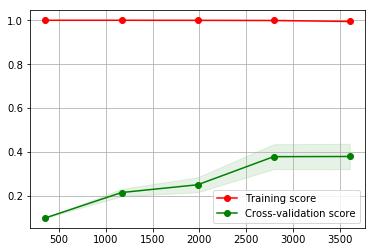

In [25]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
             label="Cross-validation score")

plt.legend(loc="best")

array([ 360, 1170, 1980, 2790, 3600])